In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from data_gen_utils.data_gen_my2 import get_simu_data
from utils.utils import MyDataSet, get_idx_sets
from demo_settings import simu_settings
from CQR import get_CQR_CIs, boosting_pred, boosting_logi, get_CF_CIs
from ddpm.train_ddpm_now import TrainDDPM
from weighted_conformal_inference import WeightedConformalInference
from naive_sample import NaiveSample
from real_data_utils import get_data_from_rawreal

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
from copy import deepcopy
plt.style.use(FIG_ROOT/"base.mplstyle")

# Params

In [82]:
data_train_raw = np.load(DATA_ROOT/"ihdp_npci_1-100.train.npz");
data_test_raw = np.load(DATA_ROOT/"ihdp_npci_1-100.test.npz");

In [84]:
params = edict()

params.nrep = 100 # num of reptition for simulation
params.K = 40 # num of sps drawn from q(Y(1)|X)
params.save_snapshot = 500
params.df_dtype = torch.float32
params.device="cpu"
params.n_jobs = 20
params.verbose = True
params.inf_bs = 40 # the inference batch, fct x K

params.ddpm_training = edict()
# Batch size during training
params.ddpm_training.batch_size = 256 
# Number of training epochs
params.ddpm_training.n_epoch = 1000
params.ddpm_training.n_infeat = 128
# Learning rate for optimizers
params.ddpm_training.lr = 0.001
params.ddpm_training.lr_gamma = 0.5
params.ddpm_training.lr_step = 1000
params.ddpm_training.test_intv = 5
params.ddpm_training.n_T = 400 # 100
params.ddpm_training.n_upblk = 1
params.ddpm_training.n_downblk = 1
params.ddpm_training.weight_decay = 1e-2
params.ddpm_training.early_stop = False
params.ddpm_training.early_stop_dict = {"early_stop_len":50, "early_stop_eps": 5e-4}
#params.ddpm_training.betas = [0.001, 0.5]

params.wconformal = edict()
# remove too large and too small in ws/mean(ws)
params.wconformal.nwthigh = 20
params.wconformal.nwtlow = 0.05
params.wconformal.useinf = False


tmp_data = get_data_from_rawreal(data_train_raw, rep_ix=0, nrep=params.nrep);
tmp_data1 = get_data_from_rawreal(data_test_raw, rep_ix=0, nrep=params.nrep);
tmp_data.X.shape
params.simu_setting = edict()
params.simu_setting.n = tmp_data.X.shape[0]
params.simu_setting.d = tmp_data.X.shape[1]
params.simu_setting.ntest = tmp_data1.X.shape[0]
params.simu_setting.cal_ratio = 0.25 # for conformal inference
params.simu_setting.val_ratio = 0.15 # for tuning network
pprint(params.simu_setting)

params.hypo_test = edict()
params.hypo_test.alpha = 0.05 # sig level

params.prefix = ""
params.save_dir = f"demo_ddpm_real_test11"
if not (RES_ROOT/params.save_dir).exists():
    (RES_ROOT/params.save_dir).mkdir()

{'cal_ratio': 0.25, 'd': 25, 'n': 672, 'ntest': 75, 'val_ratio': 0.15}


In [96]:
tmp_data.T.sum()

123.0

In [95]:
tmp_data1.X.shape

(75, 25)

In [88]:
torch.set_default_dtype(params.df_dtype)

In [89]:
keys = ["lr", "n_infeat", "n_T", "weight_decay", "n_upblk", "n_downblk"]
def _get_name_postfix(keys, ddpm_training):
    lst = []
    for key in keys:
        if ddpm_training[key] >= 1:
            lst.append(f"{key}-{str(ddpm_training[key])}")
        else:
            lst.append(f"{key}--{str(ddpm_training[key]).split('.')[-1]}")
    return "_".join(lst)

# Some fns

In [76]:
rep_ix = 0
params = params
lr = 1e-2
n_infeat = 128
n_T = 400
weight_decay = 1e-2
n_blk = 5
params.ddpm_training.n_epoch = 1000
if True:
#def _main_fn(rep_ix, params, lr, n_infeat, n_T, weight_decay, n_blk):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    params = edict(deepcopy(params))
    params.ddpm_training.n_upblk = n_blk
    params.ddpm_training.n_downblk = n_blk
    params.ddpm_training.weight_decay = weight_decay
    params.ddpm_training.n_T = n_T
    params.ddpm_training.lr = lr
    params.ddpm_training.n_infeat = n_infeat
    keys = ["lr", "n_infeat", "n_T", "weight_decay", "n_upblk", "n_downblk"]
    post_fix = _get_name_postfix(keys, params.ddpm_training)
    
    torch.set_default_dtype(params.df_dtype)
    torch.set_default_device(params.device)
    
    fil_name = (RES_ROOT/params.save_dir)/f"rep_{rep_ix}_{post_fix}_res.pkl"
    ofil_name = (RES_ROOT/params.save_dir)/f"rep_{rep_ix}_others_res.pkl"
        
        
    if True:
    #if not fil_name.exists():
        data_train = get_data_from_rawreal(data_train_raw, rep_ix=rep_ix, nrep=params.nrep)
        data_train.Y[data_train.T==1] = 0
        data_train.Y1 = np.zeros_like(data_train.Y1)
        data_test = get_data_from_rawreal(data_test_raw, rep_ix=rep_ix, nrep=params.nrep)
        data_test.Y[data_test.T==1] = 0
        data_test.Y1 = np.zeros_like(data_test.Y1)
        
        
        cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T==0)[0], 
                                                       ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
                
        _, _, trT1_idxs = get_idx_sets(all_idxs=np.where(data_train.T==1)[0], 
                                                       ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
        trboth_idxs = np.sort(np.concatenate([trT1_idxs, tr_idxs]))
        # get psfun
        psY = data_train.T[trboth_idxs].astype(int)
        psX = data_train.X[trboth_idxs]
        fit_res = boosting_logi(psY, psX);
        def wsfun(X):
            eps=1e-10
            if isinstance(X, torch.Tensor):
                X = X.cpu().numpy()
            if X.ndim == 1:
                X = X.reshape(1, -1)
            est_ps = boosting_pred(X, fit_res)
            est_ws = 1/(1-est_ps+eps)
            return torch.tensor(est_ws, dtype=params.df_dtype).to(device=params.device)
            
        
        cal_X = torch.tensor(data_train.X[cal_idxs], dtype=params.df_dtype)
        cal_Y = torch.tensor(data_train.Y0[cal_idxs], dtype=params.df_dtype)
        val_X = torch.tensor(data_train.X[val_idxs], dtype=params.df_dtype)
        val_Y = torch.tensor(data_train.Y0[val_idxs], dtype=params.df_dtype)
        test_X = torch.tensor(data_test.X, dtype=params.df_dtype)
        test_Y = torch.tensor(data_test.Y0, dtype=params.df_dtype)
            
        # train q(Y(1)|X)
        data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
        data_val = edict()
        data_val.c = val_X
        data_val.x = val_Y
        input_params = edict(deepcopy(params.ddpm_training))
        input_params.pop("n_epoch")
        input_params.pop("early_stop")
        input_params.pop("early_stop_dict")
        myddpm = TrainDDPM(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}_{post_fix}", 
                           device=params.device,
                           **input_params);
        
        
        myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
                         data_val=data_val, save_snapshot=params.save_snapshot, 
                         early_stop=params.ddpm_training.early_stop, 
                         early_stop_dict=params.ddpm_training.early_stop_dict
                         )
        def _inner_fn(X, Y, ddpm, gen_type="ddpm", gen_params={"ddim_eta": 1}):
            wcf = WeightedConformalInference(cal_X, 
                                             cal_Y,
                                             ddpm, ws_fn=wsfun, verbose=2, 
                                             gen_type=gen_type,
                                             seed=manualSeed,
                                             n_jobs=params.n_jobs,
                                             inf_bs=params.inf_bs,
                                             device=params.device,
                                             gen_params=gen_params,
                                             wcf_params={
                                                "K": params.K, # num of sps for each X
                                                "nwhigh" : params.wconformal.nwthigh,
                                                "nwlow" : params.wconformal.nwtlow,
                                                "useinf": params.wconformal.useinf,
                                             })
            # get the len of CI based on intvs, there intvs is a list, each ele is another list contains CIs ele=[CI1, CI2]
            _get_intvs_len = lambda intvs: np.array([sum([np.diff(iv) for iv in intv])[0] for intv in intvs]);
            # get weather vaule in vs is in CI in intvs or not 
            def _get_inset(vs, intvs):
                in_set = []
                for v, intv in zip(vs, intvs):
                    in_set.append(np.sum([np.bitwise_and(v>iv[0], v<iv[1]) for iv in intv]))
                in_set = np.array(in_set)
                return in_set
            intvs = wcf(X, alpha=params.hypo_test.alpha)
            prbs = np.mean(_get_inset(Y, intvs))
            mlen = np.median(_get_intvs_len(intvs))
            return prbs, mlen
        
            
            
        
        # get the results
        res_all = edict()
        
        # results under the final model
        ddpm = myddpm.ddpm
        ddpm.eval()
        res_all.DDIM = _inner_fn(test_X, test_Y, ddpm, gen_type="ddim")
        res_all.DDIM_val = _inner_fn(val_X, val_Y, ddpm, gen_type="ddim")
        
        # naive way
        def _naive_sps(tX, tY, ddpm):
            sampler = NaiveSample(ddpm, gen_type="ddim", verbose=params.verbose, device=params.device, gen_params={})
            if not isinstance(tY, np.ndarray):
                tY = tY.cpu().numpy()
            predYs = sampler.gen_fn_wrapper(tX, nsps=200, inf_bs=5, seed=manualSeed, n_jobs=params.n_jobs);
            naive_CIs = torch.quantile(predYs, torch.tensor([params.hypo_test.alpha/2, 1-params.hypo_test.alpha/2], 
                                                        dtype=params.df_dtype), axis=1).T.cpu().numpy();
            mlen_naive = np.median(naive_CIs[:, 1] -  naive_CIs[:, 0])
            prb_Y0_naive = np.bitwise_and(tY>naive_CIs[:, 0], tY<naive_CIs[:, 1]).mean()
            return (prb_Y0_naive, mlen_naive)
        #res_all.naive = _naive_sps(test_X, test_Y, ddpm)
        #res_all.naive_val = _naive_sps(val_X, val_Y, ddpm)
       
            
            
        for model_ix in range(params.save_snapshot, params.ddpm_training.n_epoch, params.save_snapshot):
            ddpm = myddpm.get_model(model_ix)
            ddpm.eval()
            res_all[f"DDIM_ep{model_ix}"] = _inner_fn(test_X, test_Y, ddpm, gen_type="ddim")
            res_all[f"DDIM_ep{model_ix}_val"] = _inner_fn(val_X, val_Y, ddpm, gen_type="ddim")
            #res_all[f"naive_ep{model_ix}"] = _naive_sps(test_X, test_Y, ddpm)
            #res_all[f"naive_ep{model_ix}_val"] = _naive_sps(val_X, val_Y, ddpm)
            
            
        # results from CQR
        CQR_CIs = get_CQR_CIs(X=data_train.X, Y=data_train.Y, 
                              T=data_train.T, Xtest=data_test.X, 
                              nav=1, 
                              alpha=params.hypo_test.alpha, 
                              estimand="unconditional",
                              fyx_est="quantBoosting", seed=manualSeed)
        mlen_cqr = np.median(CQR_CIs[:, 1] -  CQR_CIs[:, 0])
        prb_Y0_cqr = np.bitwise_and(data_test.Y0>CQR_CIs[:, 0], data_test.Y0<CQR_CIs[:, 1]).mean()
        res_all.CQR = (prb_Y0_cqr, mlen_cqr)
        
        # results from CF
        CF_CIs = get_CF_CIs(X=data_train.X, Y=data_train.Y, 
                              T=data_train.T, Xtest=data_test.X, 
                              seed=manualSeed)
        mlen_cf = np.median(CF_CIs[:, 1] -  CF_CIs[:, 0])
        prb_Y0_cf = np.bitwise_and((-data_test.Y0)>CF_CIs[:, 0], (-data_test.Y0)<CF_CIs[:, 1]).mean()
        res_all.CF= (prb_Y0_cf, mlen_cf)
        
        
        save_pkl((RES_ROOT/params.save_dir)/f"rep_{rep_ix}_{post_fix}_res.pkl", res_all, is_force=True)
        all_models = list(myddpm.save_dir.glob(f"{myddpm.prefix}ddpm_epoch*.pth"))
        [m.unlink() for m in all_models]
    else:
        res_all = edict()
        print(f"As {fil_name} exists, we do not do anything")

2024-01-28 13:06:14,667 - ddpm.train_ddpm_now - INFO - The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_real_test11.
INFO:ddpm.train_ddpm_now:The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_real_test11.
2024-01-28 13:06:14,693 - ddpm.train_ddpm_now - INFO - The params is {'lr': 0.01, 'batch_size': 256, 'device': 'cpu', 'n_T': 400, 'n_infeat': 128, 'n_upblk': 5, 'n_downblk': 5, 'betas': [0.0001, 0.02], 'lr_gamma': 0.5, 'lr_step': 1000, 'test_intv': 5, 'weight_decay': 0.01}
INFO:ddpm.train_ddpm_now:The params is {'lr': 0.01, 'batch_size': 256, 'device': 'cpu', 'n_T': 400, 'n_infeat': 128, 'n_upblk': 5, 'n_downblk': 5, 'betas': [0.0001, 0.02], 'lr_gamma': 0.5, 'lr_step': 1000, 'test_intv': 5, 'weight_decay': 0.01}
2024-01-28 13:06:14,694 - ddpm.train_ddpm_now - WARNING - We do not do early stop, so any args in early_stop_dict are ignored.


The num of params is 1.37m. 
Adjusting learning rate of group 0 to 1.0000e-02.


loss: 0.2052:  50%|█████████████████████▍                     | 498/1000 [00:30<00:34, 14.72it/s, val loss=0.799]2024-01-28 13:06:44,948 - ddpm.train_ddpm_now - INFO - Save model rep0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-5_n_downblk-5_ddpm_epoch500.pth.
INFO:ddpm.train_ddpm_now:Save model rep0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-5_n_downblk-5_ddpm_epoch500.pth.
loss: 0.2052: 100%|███████████████████████████████████████████▉| 998/1000 [01:01<00:00, 16.64it/s, val loss=1.51]2024-01-28 13:07:15,720 - ddpm.train_ddpm_now - INFO - Save model rep0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-5_n_downblk-5_ddpm_epoch1000.pth.
INFO:ddpm.train_ddpm_now:Save model rep0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-5_n_downblk-5_ddpm_epoch1000.pth.
loss: 0.2052: 100%|███████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.37it/s, val loss=1.51]
2024-01-28 13:07:15,802 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'n

Adjusting learning rate of group 0 to 5.0000e-03.


100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1181.83it/s]
2024-01-28 13:07:25,239 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
INFO:weighted_conformal_inference:wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
2024-01-28 13:07:25,241 - weighted_conformal_inference - INFO - gen params is {'ddim_timesteps': 50, 'ddim_eta': 1, 'gen_type': 'ddim'}
INFO:weighted_conformal_inference:gen params is {'ddim_timesteps': 50, 'ddim_eta': 1, 'gen_type': 'ddim'}
100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1722.98it/s]
2024-01-28 13:07:34,082 - ddpm.train_ddpm_now - INFO - We load model /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_real_test11/rep0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-5_n_downblk-5_ddpm_epoch

Save to /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_real_test11/rep_0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-5_n_downblk-5_res.pkl


In [92]:
prb_Y0_cf = np.bitwise_and((-data_test.Y0)>CF_CIs[:, 0], (-data_test.Y0)<CF_CIs[:, 1]).mean()

0.13333333333333333

In [77]:
res_all

{'DDIM': [0.92, 4.324089],
 'DDIM_val': [0.926829268292683, 4.56832],
 'DDIM_ep500': [0.9066666666666666, 6.4914274],
 'DDIM_ep500_val': [0.9024390243902439, 6.651561],
 'CQR': [0.5066666666666667, 4.300687282623509],
 'CF': [0.0, 0.49374900133332833]}

In [48]:
def _inner_fn1(X, Y, ddpm, gen_type="ddpm", gen_params={"ddim_eta": 1}):
    wcf = WeightedConformalInference(cal_X, 
                                       cal_Y,
                                       ddpm, ws_fn=wsfun, verbose=2, 
                                       gen_type=gen_type,
                                       seed=manualSeed,
                                       n_jobs=params.n_jobs,
                                       inf_bs=params.inf_bs,
                                       device=params.device,
                                       gen_params=gen_params,
                                       wcf_params={
                                          "K": params.K, # num of sps for each X
                                          "nwhigh" : params.wconformal.nwthigh,
                                          "nwlow" : params.wconformal.nwtlow,
                                          "useinf": params.wconformal.useinf,
                                       })
    # get the len of CI based on intvs, there intvs is a list, each ele is another list contains CIs ele=[CI1, CI2]
    _get_intvs_len = lambda intvs: np.array([sum([np.diff(iv) for iv in intv])[0] for intv in intvs]);
    # get weather vaule in vs is in CI in intvs or not 
    def _get_inset(vs, intvs):
        in_set = []
        for v, intv in zip(vs, intvs):
            in_set.append(np.sum([np.bitwise_and(v>iv[0], v<iv[1]) for iv in intv]))
        in_set = np.array(in_set)
        return in_set
    intvs = wcf(X, alpha=params.hypo_test.alpha)
    prbs = np.mean(_get_inset(Y, intvs))
    mlen = np.median(_get_intvs_len(intvs))
    return intvs, Y
    
res = _inner_fn1(val_X, val_Y, ddpm, gen_type="ddim",  gen_params={"ddim_eta": 1, 'ddim_timesteps': 500})
_get_intvs_len = lambda intvs: np.array([sum([np.diff(iv) for iv in intv])[0] for intv in intvs]);
        

2024-01-28 12:28:41,489 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
INFO:weighted_conformal_inference:wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
2024-01-28 12:28:41,491 - weighted_conformal_inference - INFO - gen params is {'ddim_timesteps': 500, 'ddim_eta': 1, 'gen_type': 'ddim'}
INFO:weighted_conformal_inference:gen params is {'ddim_timesteps': 500, 'ddim_eta': 1, 'gen_type': 'ddim'}
100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1499.04it/s]


In [52]:
_get_intvs_len(res[0]).mean()

159.35828

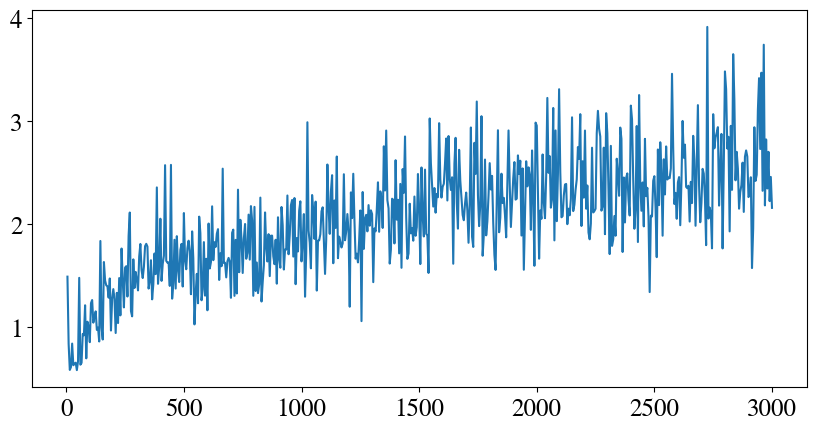

In [19]:
x, y = np.array(myddpm.losses_val)[:, 0], np.array(myddpm.losses_val)[:, 1]
plt.plot(x, y)

In [122]:
ddpm = myddpm.get_model(1500)
ddpm.eval()
res_all.DDIM0_sel = _inner_fn(test_X, test_Y, ddpm, gen_type="ddim", gen_params={"ddim_eta": 1})
res_all.DDIM0_sel_val = _inner_fn(val_X, val_Y, ddpm, gen_type="ddim", gen_params={"ddim_eta": 1})

2024-01-12 12:02:18,153 - ddpm.train_ddpm_now - INFO - We load model /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting2_test11/rep0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-1_n_downblk-1_ddpm_epoch1500.pth.
2024-01-12 12:02:18,185 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
2024-01-12 12:02:18,186 - weighted_conformal_inference - INFO - wcf params is {'ddim_timesteps': 50, 'ddim_eta': 1, 'gen_type': 'ddim'}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 6298.89it/s]
2024-01-12 12:02:22,839 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
2024-01-12 12:02:22,840 - weighted_conformal_inference - INFO - wcf params is {'ddim_timesteps': 50, 'ddim_eta': 1

In [10]:
res_all

{'DDIM': [0.974, 8.088068],
 'DDIM_val': [0.9536082474226805, 8.102292],
 'DDIM_ep500': [0.951, 11.515848],
 'DDIM_ep500_val': [0.9072164948453608, 11.734699],
 'DDIM_ep1000': [0.958, 8.58436],
 'DDIM_ep1000_val': [0.9329896907216495, 8.413291],
 'DDIM_ep1500': [0.881, 9.259474],
 'DDIM_ep1500_val': [0.9020618556701031, 9.13562],
 'DDIM_ep2000': [0.98, 8.448517],
 'DDIM_ep2000_val': [0.9536082474226805, 8.400656],
 'DDIM_ep2500': [0.984, 8.410965],
 'DDIM_ep2500_val': [0.9690721649484536, 8.304659],
 'CQR': [0.961, 8.090967784201855]}

In [24]:
def _main_fn(rep_ix, params, lr, n_infeat, n_T, weight_decay, n_blk):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    params = edict(deepcopy(params))
    params.ddpm_training.n_upblk = n_blk
    params.ddpm_training.n_downblk = n_blk
    params.ddpm_training.weight_decay = weight_decay
    params.ddpm_training.n_T = n_T
    params.ddpm_training.lr = lr
    params.ddpm_training.n_infeat = n_infeat
    keys = ["lr", "n_infeat", "n_T", "weight_decay", "n_upblk", "n_downblk"]
    post_fix = _get_name_postfix(keys, params.ddpm_training)
    
    torch.set_default_dtype(params.df_dtype)
    torch.set_default_device(params.device)
    
    fil_name = (RES_ROOT/params.save_dir)/f"rep_{rep_ix}_{post_fix}_res.pkl"
        
        
    if True:
    #if not fil_name.exists():
        data_train = get_simu_data(n=params.simu_setting.n, 
                                   d=params.simu_setting.d, 
                                   is_homo=params.simu_setting.is_homo, 
                                   rho=params.simu_setting.rho, 
                                   err_type=params.simu_setting.err_type);
        data_test = get_simu_data(n=params.simu_setting.ntest, 
                                   d=params.simu_setting.d, 
                                   is_homo=params.simu_setting.is_homo, 
                                   rho=params.simu_setting.rho,
                                   err_type=params.simu_setting.err_type);
        
        
        cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                                       ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
                
        # get psfun
        psY = data_train.T.astype(int)
        psX = data_train.X
        fit_res = boosting_logi(psY, psX);
        def wsfun(X):
            eps=1e-10
            if isinstance(X, torch.Tensor):
                X = X.cpu().numpy()
            if X.ndim == 1:
                X = X.reshape(1, -1)
            est_ps = boosting_pred(X, fit_res)
            est_ws = 1/(est_ps+eps)
            return torch.tensor(est_ws, dtype=params.df_dtype).to(device=params.device)
            
        
        cal_X = torch.tensor(data_train.X[cal_idxs], dtype=params.df_dtype)
        cal_Y = torch.tensor(data_train.Y1[cal_idxs], dtype=params.df_dtype)
        val_X = torch.tensor(data_train.X[val_idxs], dtype=params.df_dtype)
        val_Y = torch.tensor(data_train.Y1[val_idxs], dtype=params.df_dtype)
        test_X = torch.tensor(data_test.X, dtype=params.df_dtype)
        test_Y = torch.tensor(data_test.Y1, dtype=params.df_dtype)
            
        # train q(Y(1)|X)
        data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
        data_val = edict()
        data_val.c = val_X
        data_val.x = val_Y
        input_params = edict(deepcopy(params.ddpm_training))
        input_params.pop("n_epoch")
        input_params.pop("early_stop")
        input_params.pop("early_stop_dict")
        myddpm = TrainDDPM(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}_{post_fix}", 
                           device=params.device,
                           **input_params);
        
        
        myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
                         data_val=data_val, save_snapshot=params.save_snapshot, 
                         early_stop=params.ddpm_training.early_stop, 
                         early_stop_dict=params.ddpm_training.early_stop_dict
                         )
        def _inner_fn(X, Y, ddpm, gen_type="ddpm"):
            wcf = WeightedConformalInference(cal_X, 
                                             cal_Y,
                                             ddpm, ws_fn=wsfun, verbose=2, 
                                             gen_type=gen_type,
                                             seed=manualSeed,
                                             n_jobs=params.n_jobs,
                                             inf_bs=params.inf_bs,
                                             device=params.device,
                                             gen_params={"ddim_eta": 1},
                                             wcf_params={
                                                "K": params.K, # num of sps for each X
                                                "nwhigh" : params.wconformal.nwthigh,
                                                "nwlow" : params.wconformal.nwtlow,
                                                "useinf": params.wconformal.useinf,
                                             })
            # get the len of CI based on intvs, there intvs is a list, each ele is another list contains CIs ele=[CI1, CI2]
            _get_intvs_len = lambda intvs: np.array([sum([np.diff(iv) for iv in intv])[0] for intv in intvs]);
            # get weather vaule in vs is in CI in intvs or not 
            def _get_inset(vs, intvs):
                in_set = []
                for v, intv in zip(vs, intvs):
                    in_set.append(np.sum([np.bitwise_and(v>iv[0], v<iv[1]) for iv in intv]))
                in_set = np.array(in_set)
                return in_set
            intvs = wcf(X, alpha=params.hypo_test.alpha)
            prbs = np.mean(_get_inset(Y, intvs))
            mlen = np.median(_get_intvs_len(intvs))
            return prbs, mlen
        
            
            
        
        # get the results
        res_all = edict()
        
        # results under the final model
        ddpm = myddpm.ddpm
        ddpm.eval()
        #res_all.DDPM = _inner_fn(test_X, test_Y, ddpm)
        res_all.DDIM = _inner_fn(test_X, test_Y, ddpm, gen_type="ddim")
        #res_all.DDPM_val = _inner_fn(val_X, val_Y, ddpm)
        res_all.DDIM_val = _inner_fn(val_X, val_Y, ddpm, gen_type="ddim")
            
            
        # results under the best model in terms of the error from val set
        ddpm = myddpm.get_opt_model()
        ddpm.eval()
        #res_all.DDPM_sel = _inner_fn(test_X, test_Y, ddpm)
        res_all.DDIM_sel = _inner_fn(test_X, test_Y, ddpm, gen_type="ddim")
        #res_all.DDPM_sel_val = _inner_fn(val_X, val_Y, ddpm)
        res_all.DDIM_sel_val = _inner_fn(val_X, val_Y, ddpm, gen_type="ddim")
            
            
        # results from CQR
        CQR_CIs = get_CQR_CIs(X=data_train.X, Y=data_train.Y, 
                              T=data_train.T, Xtest=data_test.X, 
                              nav=0, 
                              alpha=params.hypo_test.alpha, 
                              estimand="unconditional",
                              fyx_est="quantBoosting", seed=manualSeed)
        mlen_cqr = np.median(CQR_CIs[:, 1] -  CQR_CIs[:, 0])
        prb_Y1_cqr = np.bitwise_and(data_test.Y1>CQR_CIs[:, 0], data_test.Y1<CQR_CIs[:, 1]).mean()
        #prb_tau_cqr = np.bitwise_and(data_test.tau>CQR_CIs[:, 0], data_test.tau<CQR_CIs[:, 1]).mean()
        
        res_all.CQR = (prb_Y1_cqr, mlen_cqr)
        save_pkl((RES_ROOT/params.save_dir)/f"rep_{rep_ix}_{post_fix}_res.pkl", res_all, is_force=True)
        all_models = list(myddpm.save_dir.glob(f"{myddpm.prefix}ddpm_epoch*.pth"))
        [m.unlink() for m in all_models]
    else:
        res_all = edict()
        print(f"As {fil_name} exists, we do not do anything")
    return res_all, myddpm

In [25]:
res_all = _main_fn(rep_ix=0, params=params, lr=1e-2, n_infeat=128, n_T=400, weight_decay=1e-2, n_blk=1)

2024-01-11 12:35:48,578 - ddpm.train_ddpm_now - INFO - The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting2_test11.
2024-01-11 12:35:48,587 - ddpm.train_ddpm_now - INFO - The params is {'lr': 0.01, 'batch_size': 256, 'device': 'cpu', 'n_T': 400, 'n_infeat': 128, 'n_upblk': 1, 'n_downblk': 1, 'betas': [0.0001, 0.02], 'lr_gamma': 0.5, 'lr_step': 1000, 'test_intv': 5, 'weight_decay': 0.01}
2024-01-11 12:35:48,588 - ddpm.train_ddpm_now - WARNING - We do not do early stop, so any args in early_stop_dict are ignored.


The num of params is 0.32m. 
Adjusting learning rate of group 0 to 1.0000e-02.


loss: 0.2447:  33%|███████████████████████████████████                                                                      | 1003/3000 [00:37<01:26, 23.06it/s, val loss=1.38]

Adjusting learning rate of group 0 to 5.0000e-03.


loss: 0.1959:  67%|██████████████████████████████████████████████████████████████████████▏                                  | 2005/3000 [01:14<00:33, 29.76it/s, val loss=1.51]

Adjusting learning rate of group 0 to 2.5000e-03.


loss: 0.1746: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:49<00:00, 27.30it/s, val loss=2.02]
2024-01-11 12:37:38,493 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
2024-01-11 12:37:38,493 - weighted_conformal_inference - INFO - wcf params is {'ddim_timesteps': 50, 'ddim_eta': 1, 'gen_type': 'ddim'}


Adjusting learning rate of group 0 to 1.2500e-03.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1237.17it/s]
2024-01-11 12:37:47,189 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
2024-01-11 12:37:47,190 - weighted_conformal_inference - INFO - wcf params is {'ddim_timesteps': 50, 'ddim_eta': 1, 'gen_type': 'ddim'}
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2450.23it/s]
2024-01-11 12:37:49,428 - ddpm.train_ddpm_now - INFO - We load model /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting2_test11/rep0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-1_n_downblk-1_ddpm_epoch200.pth with val loss 0.730.
2024-01-11 12:37:49,540 - weighted_conformal_inference - INFO - wcf par

Save to /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting2_test11/rep_0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-1_n_downblk-1_res.pkl


({'DDIM': [0.947, 5.902583],
  'DDIM_val': [0.93048128342246, 5.926076],
  'DDIM_sel': [0.944, 7.4418364],
  'DDIM_sel_val': [0.946524064171123, 7.41542],
  'CQR': [0.961, 6.726642395023848]},
 <ddpm.train_ddpm_now.TrainDDPM at 0x7f8d4b72ca60>)

In [26]:
res_all

({'DDIM': [0.947, 5.902583],
  'DDIM_val': [0.93048128342246, 5.926076],
  'DDIM_sel': [0.944, 7.4418364],
  'DDIM_sel_val': [0.946524064171123, 7.41542],
  'CQR': [0.961, 6.726642395023848]},
 <ddpm.train_ddpm_now.TrainDDPM at 0x7f8d4b72ca60>)

In [29]:
myddpm = res[1]

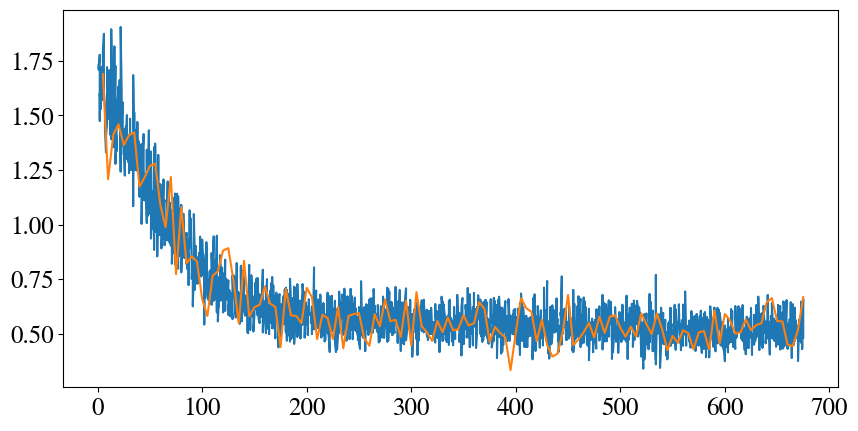

In [30]:
eps = np.array(myddpm.losses)[:, 0]
loss = np.array(myddpm.losses)[:, 1]
eps_val = np.array(myddpm.losses_val)[:, 0]
loss_val = np.array(myddpm.losses_val)[:, 1];
plt.plot(eps, loss)
plt.plot(eps_val, loss_val)

# evaluate

In [11]:
data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);

Y1t = torch.tensor(data_test.Y1, dtype=params.df_dtype)
Xt = torch.tensor(data_test.X, dtype=params.df_dtype);

In [13]:
ress = []
for m_ix in list(range(500, 3000, 500)):
    ddpm = myddpm.get_model(m_ix);
    ddpm.eval()
    with torch.no_grad():
        loss = ddpm(Y1t, Xt)
        x_i, x_is = ddpm.sample_ddim(Xt, device="cpu", is_store=False, ddim_eta=1);
    ress.append([m_ix, loss.item(), torch.mean((Y1t - x_i.reshape(-1))**2).item()])


ValueError: attempt to get argmin of an empty sequence

Text(0, 0.5, 'MSE')

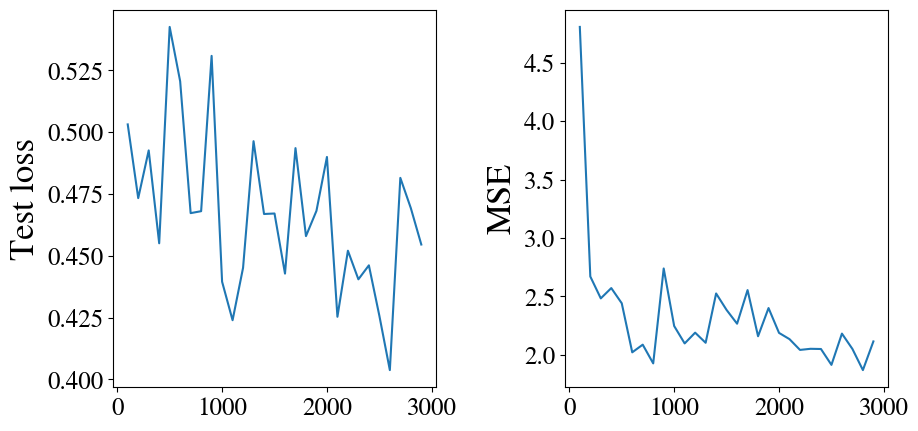

In [133]:
ress = np.array(ress);
plt.subplot(121)
plt.plot(ress[:, 0], ress[:, 1])
plt.ylabel("Test loss")
plt.subplot(122)
plt.plot(ress[:, 0], ress[:, 2])
plt.ylabel("MSE")

## ON test set

In [61]:
ddpm = myddpm.get_model(200);

2024-01-12 11:06:36,720 - ddpm.train_ddpm_now - INFO - We load model /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting2_test11/rep0_lr--01_n_infeat-128_n_T-400_weight_decay--01_n_upblk-1_n_downblk-1_ddpm_epoch200.pth.


In [62]:
data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);

In [63]:
tX = torch.tensor(data_test.X);
c = tX.type(params.df_dtype);

In [64]:
ddpm.eval()
with torch.no_grad():
    x_i, x_is = ddpm.sample_ddim(c, device="cpu", is_store=False, ddim_eta=1);

(-20.0, 20.0)

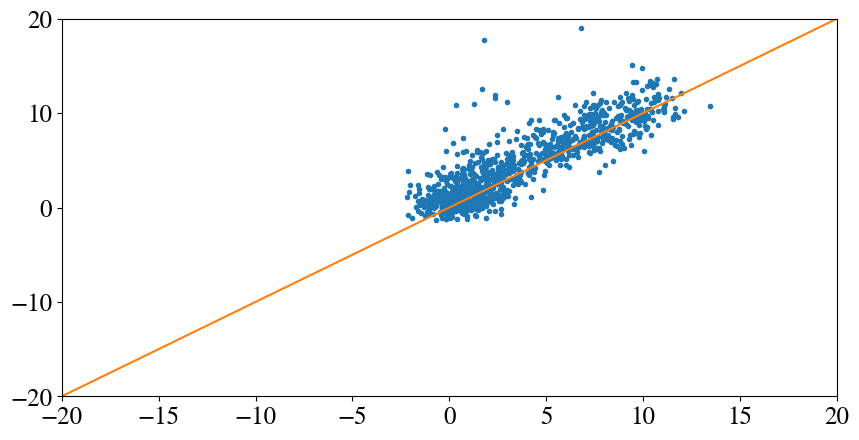

In [65]:
predx0 = x_i.reshape(-1).numpy();
x0 = data_test.Y1;
plt.plot(x0, predx0, ".")
xx = np.linspace(-20, 20, 100)
yy = xx
plt.plot(xx, yy)
plt.xlim([-20, 20])
plt.ylim([-20, 20])

## Given X

In [ ]:
list(range(10,0, -1)

In [41]:
datatest_con = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho, 
                               is_condition=True);
tX_con = torch.tensor(datatest_con.X);
c = tX_con.type(params.dftype);

In [42]:
ddpm.eval()
with torch.no_grad():
    x_i, x_is = ddpm.sample(c, device="cpu", guide_w=0);

(-5.0, 10.0)

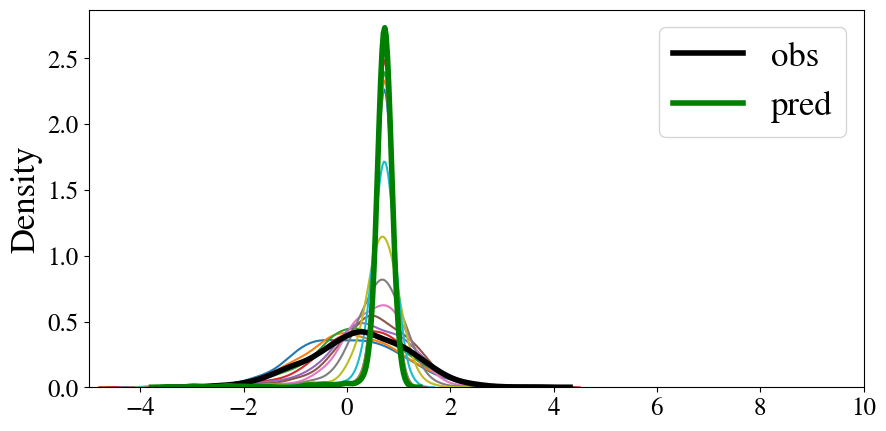

In [43]:
predx0 = x_i.reshape(-1).numpy();
x0 = datatest_con.Y1;
x_is = x_is.squeeze();
for idx in range(x_is.shape[0]):
    sns.kdeplot(x_is[idx])
sns.kdeplot(x0, color="black", lw=4, label="obs")
sns.kdeplot(predx0, color="green", lw=4, label="pred")
plt.legend()
plt.xlim([-5, 10])

# bak

In [9]:
def _run_fn_PCP(rep_ix):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    torch.set_default_dtype(params.dftype)
    torch.set_default_device(params.device)
    
    #beta = np.concatenate([np.random.randn(2), np.zeros(params.simu_setting.d-2)])
    #inp = np.random.randn(1) * 10                                
    
    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    
    cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
        
        
    # train q(Y(1)|X)
    # I skip this for now, suppose you get one
    data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
    data_val = edict()
    data_val.c =  data_train.X[val_idxs]
    data_val.x =  data_train.Y[val_idxs]
    
    input_params = params.ddpm_training.copy()
    input_params.pop("n_epoch")
    myddpm = TrainDDPM(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}", 
                       device=params.device,
                       **input_params);
    #myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
    #             data_val=data_val, save_snapshot=params.save_snapshot)
    ddpm = myddpm.ddpm
    #ddpm = myddpm.get_opt_model()
    ddpm = myddpm.get_model(500)
    ddpm.eval()
    
    ## propensity score
    ## I can use all data in train set (including cal set)
    #from sklearn.linear_model import LogisticRegression
    #clf = LogisticRegression(random_state=0)
    #psY = data_train.T.astype(int)
    #psX = data_train.X
    #clf = clf.fit(psX, psY);
    #def psfun(x):
    #    if x.ndim == 1:
    #        x = x.reshape(1, -1)
    #    return clf.predict_proba(x)[:, 1]
    #
    #
    ## weight function
    #def wtfun(x):
    #    # for unconditional weight
    #    return 1/psfun(x)
    
    # weight function
    def wtfun(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        # for unconditional weight
        return np.ones(x.shape[0])
        
    # get the weight and nonconformity score for each data point in cal set
    x_0s = _gen_Y_given_X(data_train.X[cal_idxs], ddpm, manualSeed)
    ws = wtfun(data_train.X[cal_idxs]);
    Es = np.abs(x_0s -  data_train.Y1[cal_idxs][:, None]).min(axis=1);
            
    def _run_fn2(te_idx):
        torch.set_default_dtype(params.dftype)
        teX = data_test.X[te_idx]
        teY1 = data_test.Y1[te_idx]
        tetau = data_test.tau[te_idx]
        
        # get qv for current test pt
        ws_wtest = np.concatenate([ws, wtfun(teX)]);
        Es_winf = np.concatenate([Es, [np.inf]]);
        nws_wtest = ws_wtest/ws_wtest.mean();
        nws_wtest[nws_wtest<params.wconformal.nwtlow] = params.wconformal.nwtlow
        nws_wtest[nws_wtest>params.wconformal.nwthigh] = params.wconformal.nwthigh
        # can not take the inf into consider
        #qv_cur = weighted_quantile(Es_winf, [1-params.hypo_test.alpha], sample_weight=nws_wtest);
        qt = (1 + nws_wtest[-1]/ nws_wtest[:-1].sum()) * (1 - params.hypo_test.alpha)
        if qt <= 1:
            qv_cur = weighted_quantile(Es, [qt], sample_weight=ws_wtest[:-1]);
        else:
            if params.wconformal.useinf:
                qv_cur = np.inf
            else:
                qv_cur = np.max(Es)
        
        intvs = _get_pred_intv(teYs_hat[te_idx], qv_cur)
        res = _get_metric([teY1, tetau], intvs)
        res["qv_cur"] = qv_cur
        res["qt"] = qt
        res["intvs"] = intvs
        return res
        
    teYs_hat = _gen_Y_given_X(data_test.X, ddpm, manualSeed);
    pbar2 = range(params.simu_setting.ntest)
    with Parallel(n_jobs=1) as parallel:
        test_res = parallel(delayed(_run_fn2)(te_idx) for te_idx in pbar2)
        
    prbs = np.mean([res['in_sets'] for res in test_res], axis=0)
    mlen = np.median([res['intvs_len'] for res in test_res])
        
        
    # results from CQR
    CQR_CIs = get_CQR_CIs(X=data_train.X, Y=data_train.Y, 
                          T=data_train.T, Xtest=data_test.X, 
                          nav=0, 
                          alpha=params.hypo_test.alpha, 
                          estimand="nonmissing",
                          fyx_est="quantBoosting", seed=manualSeed)
    mlen_cqr = np.median(CQR_CIs[:, 1] -  CQR_CIs[:, 0])
    prb_Y1_cqr = np.bitwise_and(data_test.Y1>CQR_CIs[:, 0], data_test.Y1<CQR_CIs[:, 1]).mean()
    prb_tau_cqr = np.bitwise_and(data_test.tau>CQR_CIs[:, 0], data_test.tau<CQR_CIs[:, 1]).mean()
    
    res_all = edict()
    res_all.DDPM = (prbs, mlen)
    res_all.CQR = ([prb_Y1_cqr, prb_tau_cqr], mlen_cqr)
    return res_all, myddpm, test_res, np.abs(x_0s -  data_train.Y1[cal_idxs][:, None])

In [25]:
def _run_fn_naive_quan(rep_ix):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    torch.set_default_dtype(params.dftype)
    torch.set_default_device(params.device)
    
    #beta = np.concatenate([np.random.randn(2), np.zeros(params.simu_setting.d-2)])
    #inp = np.random.randn(1) * 10                                
    
    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    
    cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
        
        
    # train q(Y(1)|X)
    # I skip this for now, suppose you get one
    data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
    data_val = edict()
    data_val.c =  data_train.X[val_idxs]
    data_val.x =  data_train.Y[val_idxs]
    
    input_params = params.ddpm_training.copy()
    input_params.pop("n_epoch")
    myddpm = TrainDDPM(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}", 
                       device=params.device,
                       **input_params);
    myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
                 data_val=data_val, save_snapshot=params.save_snapshot)
    ddpm = myddpm.ddpm
    #ddpm = myddpm.get_opt_model()
    #ddpm = myddpm.get_model(1000)
    ddpm.eval()
    
    teYs_hat = _gen_Y_given_X(data_test.X, ddpm, manualSeed);
    lows, ups = np.quantile(teYs_hat, [params.hypo_test.alpha/2, 1-params.hypo_test.alpha/2], axis=-1);
    prb_Y1 = np.bitwise_and(data_test.Y1>lows, data_test.Y1<ups).mean()
    prb_tau = np.bitwise_and(data_test.tau>lows, data_test.tau<ups).mean()
    mlen = np.mean(ups-lows)
        
        
    # results from CQR
    CQR_CIs = get_CQR_CIs(X=data_train.X, Y=data_train.Y, 
                          T=data_train.T, Xtest=data_test.X, 
                          nav=0, 
                          alpha=params.hypo_test.alpha, 
                          estimand="nonmissing",
                          fyx_est="quantBoosting", seed=manualSeed)
    mlen_cqr = np.mean(CQR_CIs[:, 1] -  CQR_CIs[:, 0])
    prb_Y1_cqr = np.bitwise_and(data_test.Y1>CQR_CIs[:, 0], data_test.Y1<CQR_CIs[:, 1]).mean()
    prb_tau_cqr = np.bitwise_and(data_test.tau>CQR_CIs[:, 0], data_test.tau<CQR_CIs[:, 1]).mean()
    
    res_all = edict()
    res_all.DDPM = ([prb_Y1, prb_tau], mlen)
    res_all.CQR = ([prb_Y1_cqr, prb_tau_cqr], mlen_cqr)
    return res_all, myddpm

In [42]:
def _run_fn_quanreg_now(rep_ix, model_ix=None):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    torch.set_default_dtype(params.dftype)
    torch.set_default_device(params.device)
    
    #beta = np.concatenate([np.random.randn(2), np.zeros(params.simu_setting.d-2)])
    #inp = np.random.randn(1) * 10                                
    
    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    
    cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
        
        
    # train q(Y(1)|X)
    # I skip this for now, suppose you get one
    data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
    data_val = edict()
    data_val.c =  data_train.X[val_idxs]
    data_val.x =  data_train.Y[val_idxs]
    
    input_params = params.ddpm_training.copy()
    input_params.pop("n_epoch")
    input_params.pop("early_stop")
    input_params.pop("early_stop_dict")
    myddpm = TrainDDPM_now(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}", 
                       device=params.device,
                       **input_params);
    if model_ix is None:
        myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
                     data_val=data_val, save_snapshot=params.save_snapshot, 
                     early_stop=params.ddpm_training.early_stop,
                     early_stop_dict=params.ddpm_training.early_stop_dict)
        ddpm = myddpm.ddpm
    elif isinstance(model_ix, str):
        ddpm = myddpm.get_opt_model()
    elif isinstance(model_ix, int):
        ddpm = myddpm.get_model(model_ix)
    ddpm.eval()
    
    ## propensity score
    ## I can use all data in train set (including cal set)
    #from sklearn.linear_model import LogisticRegression
    #clf = LogisticRegression(random_state=0)
    #psY = data_train.T.astype(int)
    #psX = data_train.X
    #clf = clf.fit(psX, psY);
    #def psfun(x):
    #    if x.ndim == 1:
    #        x = x.reshape(1, -1)
    #    return clf.predict_proba(x)[:, 1]
    #
    #
    ## weight function
    #def wtfun(x):
    #    # for unconditional weight
    #    return 1/psfun(x)
    
    # weight function
    def wtfun(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        # for unconditional weight
        return np.ones(x.shape[0])
        
    # get the weight and nonconformity score for each data point in cal set
    x_0s = _gen_Y_given_X(data_train.X[cal_idxs], ddpm, manualSeed)
    ws = wtfun(data_train.X[cal_idxs]);
    lows, ups = np.quantile(x_0s, [params.hypo_test.alpha/2, 1-params.hypo_test.alpha/2], axis=-1);
    Es = np.maximum(lows - data_train.Y1[cal_idxs],  data_train.Y1[cal_idxs]-ups)
            
    def _run_fn2(te_idx):
        torch.set_default_dtype(params.dftype)
        teX = data_test.X[te_idx]
        teY1 = data_test.Y1[te_idx]
        tetau = data_test.tau[te_idx]
        
        # get qv for current test pt
        ws_wtest = np.concatenate([ws, wtfun(teX)]);
        Es_winf = np.concatenate([Es, [np.inf]]);
        nws_wtest = ws_wtest/ws_wtest.mean();
        nws_wtest[nws_wtest<params.wconformal.nwtlow] = params.wconformal.nwtlow
        nws_wtest[nws_wtest>params.wconformal.nwthigh] = params.wconformal.nwthigh
        # can not take the inf into consider
        #qv_cur = weighted_quantile(Es_winf, [1-params.hypo_test.alpha], sample_weight=nws_wtest);
        qt = (1 + nws_wtest[-1]/ nws_wtest[:-1].sum()) * (1 - params.hypo_test.alpha)
        if qt <= 1:
            qv_cur = weighted_quantile(Es, [qt], sample_weight=ws_wtest[:-1])[0];
        else:
            if params.wconformal.useinf:
                qv_cur = np.inf
            else:
                qv_cur = np.max(Es)
        
        intvs = np.array([[lows_te[te_idx]-qv_cur, ups_te[te_idx]+qv_cur]])
        res = _get_metric([teY1, tetau], intvs)
        res["qv_cur"] = qv_cur
        res["qt"] = qt
        res["intvs"] = intvs
        return res
        
    teYs_hat = _gen_Y_given_X(data_test.X, ddpm, manualSeed);
    lows_te, ups_te = np.quantile(teYs_hat, [params.hypo_test.alpha/2, 1-params.hypo_test.alpha/2], axis=-1);
    pbar2 = range(params.simu_setting.ntest)
    with Parallel(n_jobs=1) as parallel:
        test_res = parallel(delayed(_run_fn2)(te_idx) for te_idx in pbar2)
        
    prbs = np.mean([res['in_sets'] for res in test_res], axis=0)
    mlen = np.median([res['intvs_len'] for res in test_res])
        
        
    # results from CQR
    CQR_CIs = get_CQR_CIs(X=data_train.X, Y=data_train.Y, 
                          T=data_train.T, Xtest=data_test.X, 
                          nav=0, 
                          alpha=params.hypo_test.alpha, 
                          estimand="nonmissing",
                          fyx_est="quantBoosting", seed=manualSeed)
    mlen_cqr = np.median(CQR_CIs[:, 1] -  CQR_CIs[:, 0])
    prb_Y1_cqr = np.bitwise_and(data_test.Y1>CQR_CIs[:, 0], data_test.Y1<CQR_CIs[:, 1]).mean()
    prb_tau_cqr = np.bitwise_and(data_test.tau>CQR_CIs[:, 0], data_test.tau<CQR_CIs[:, 1]).mean()
    
    res_all = edict()
    res_all.DDPM = (prbs, mlen)
    res_all.CQR = ([prb_Y1_cqr, prb_tau_cqr], mlen_cqr)
    return res_all, myddpm, test_res, np.abs(x_0s -  data_train.Y1[cal_idxs][:, None])